In [5]:
import ephem
import json
from shapely.geometry import shape, mapping, Point
import fiona
import gdal
import ogr, osr
import struct
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

## DEM analysis

#### Load site using shapely

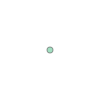

In [2]:
with open ('inputs/site.geojson') as f:
    js = json.load(f)

s = shape(js['features'][0]['geometry'])
s

#### Load digital elevation model

In [3]:
dem = gdal.Open('inputs/dem/filled.tif')

#### Reproject the site to coords of dem for sampling elevation

In [4]:
site = ogr.Geometry(ogr.wkbPoint) # create an ogr geom instead of shapely
site.AddPoint(s.x, s.y)

sr = dem.GetProjection()
destSR = osr.SpatialReference()
inSRS_converter = osr.SpatialReference()
inSRS_converter.ImportFromWkt(sr)
inSRS_proj4 = inSRS_converter.ExportToProj4()
destSR.ImportFromProj4(inSRS_proj4)

srcSR = osr.SpatialReference()
srcSR.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
srTrans = osr.CoordinateTransformation(srcSR,destSR)

site_reproj = site
site.Transform(srTrans)
print(site_reproj.ExportToWkt())

POINT (-3010468.19566961 753062.757047171 0)


#### Get site elevation

In [5]:
gt=dem.GetGeoTransform()
rb=dem.GetRasterBand(1)

def get_elev_at_point(geotransform, rasterband, pointgeom):
    mx,my=pointgeom.GetX(), pointgeom.GetY()
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - geotransform[0]) / geotransform[1]) #x pixel
    py = int((my - geotransform[3]) / geotransform[5]) #y pixel
    intval=rasterband.ReadAsArray(px,py,1,1)[0]
    return intval[0]
    
site_elev = get_elev_at_point(gt, rb, site_reproj)
site_elev

1304.3667

#### Not integrated in this notebook yet...

Did the viewshed analysis in QGIS using https://github.com/zoran-cuckovic/QGIS-visibility-analysis
SAGA or GRASS could work here

Options:
- horizon search radius 20 km
- target (site) height 2 meters above surface
- adapting out 3 pixels (15 meters/~50 feet) from site to find high spot


Kept working in qgis for speed, will convert to this notebook eventually

In QGIS the horizon was:
- converted to ascii
- imported as points

Then:
- the dem was sampled with the horizon pts
- distance to site from each point calculated (m)
- inclination angle to each point calculation: `degrees(atan((horizon_elev-site_elev)/distance)`

Bearing calculation:
```
degrees(atan(($x_at(0)-site_lon)/($y_at(0)-site_lat))) + (180 *((($y_at(0)-site_lat) < 0) + ((($x_at(0)-site_lon) < 0 AND ($y_at(0)-site_lat) >0)*2)))
```

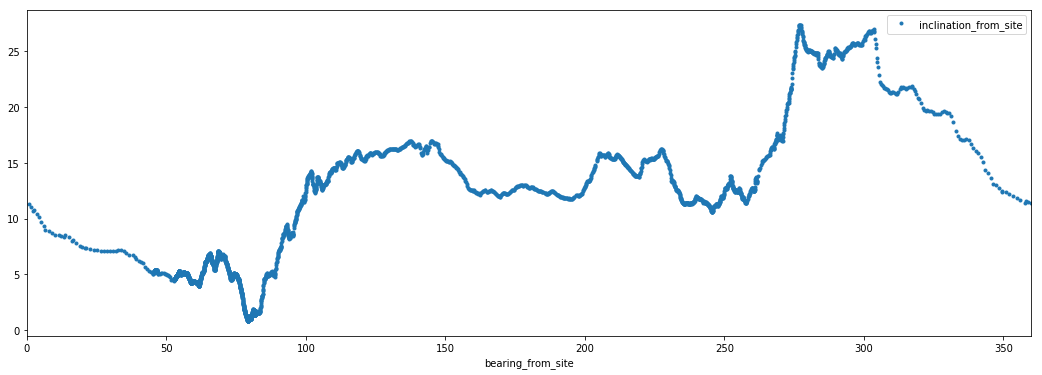

In [6]:
df = pd.read_csv('inputs/viewshed/horizon_dist.csv')
df_skyview = df.set_index('bearing_from_site')
df_skyview.plot(y='inclination_from_site', style='.', figsize=(18,6), xlim=(0, 360))

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_skyview.loc[df_skyview['inclination_from_site'].idxmax()]

long                        -149.066
lat                           61.910
epsg3413_x              -3009867.500
epsg3413_y                754147.500
elevation                   1947.183
id                           738.000
meters_from_site            1239.961
inclination_from_site         27.403
Name: 277.16245399, dtype: float64

## Solar analysis

#### Get the azimuth and altitude for the sun for every hour during the year

In [8]:
panel = ephem.Observer()
panel.lon = str(s.x) # this needs to be a string. derp
panel.lat = str(s.y)
panel.elevation = site_elev+2 # +2meters stays consistent with viewshed analysis
# panel.date = '2017/05/17 20:30:00' # utc time
panel

<ephem.Observer date='2017/5/30 20:09:48' epoch='2000/1/1 12:00:00' lon='-149:02:39.2' lat='61:54:25.8' elevation=1306.36669921875m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

In [9]:
from pytz import all_timezones, common_timezones
local = pytz.timezone('America/Anchorage')

def get_sunangles(time_utc, observer):
    observer.date = time_utc
    solar = ephem.Sun(observer)
    a = {}
    a['az'] = math.degrees(solar.az)
    a['alt'] = math.degrees(solar.alt)
    return a

get_sunangles(datetime.datetime.utcnow(), panel)

df_sun = pd.DataFrame(index=pd.date_range('2018-01-01 00:00', '2018-12-31 23:59', freq='5min', tz=local))
samples_per_hour=12 # adjust based on freq

df_sun['ts_utc'] = (df_sun.index).tz_convert(pytz.timezone('UTC'))
df_sun['az'] = df_sun.apply(lambda row: get_sunangles(row['ts_utc'], panel)['az'], axis=1)
df_sun['alt'] = df_sun.apply(lambda row: get_sunangles(row['ts_utc'], panel)['alt'], axis=1)

In [10]:
# df_sun.alt.plot(figsize=(18,6))

#### Interpolate the DEM derived skyview

In [11]:
skyview_bearings = df_skyview.index.tolist()
azimuths = df_sun.az.tolist()
all_bearings = list(skyview_bearings)
all_bearings.extend(x for x in azimuths if x not in all_bearings)
df_allbearings = df_skyview.reindex(all_bearings)
df_allbearings.sort_index(inplace=True)
df_allbearings = df_allbearings.inclination_from_site.interpolate().ffill().bfill()

In [12]:
# df_allbearings.plot(kind='area', figsize=(18,6))

#### Can the site see the sun???

In [13]:
df_viz = df_sun.join(df_allbearings, on='az')
df_viz['visible'] = False
df_viz.loc[df_viz['alt'] > df_viz['inclination_from_site'], 'visible'] = True

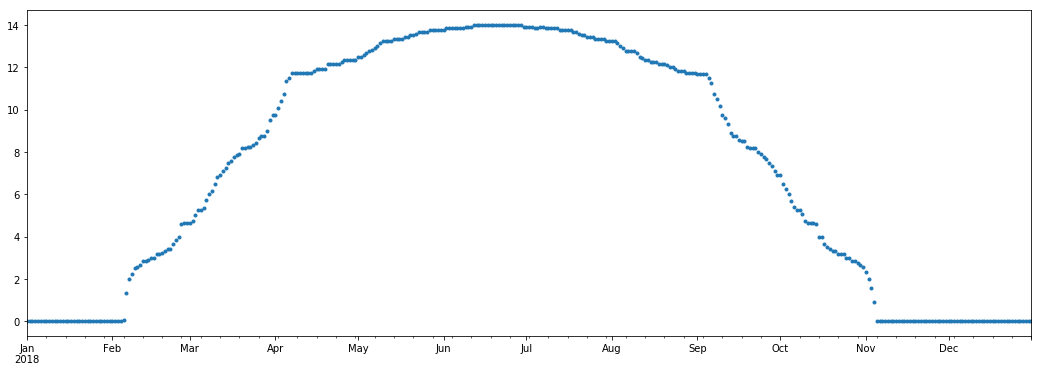

In [14]:
series_dailysum = df_viz.groupby(pd.TimeGrouper(freq='D'))['visible'].sum()/samples_per_hour
series_dailysum.plot(figsize=(18,6), style='.')

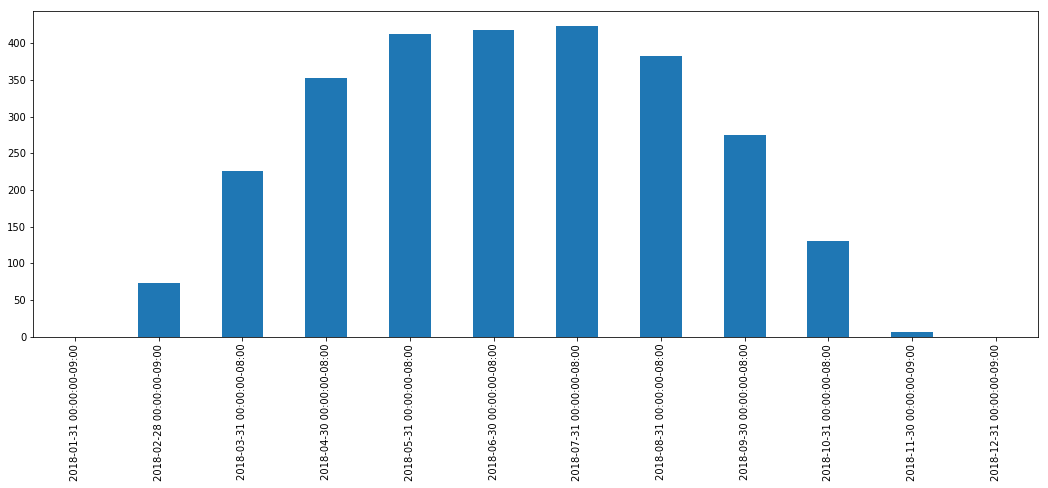

In [15]:
series_monthlysum = df_viz.groupby(pd.TimeGrouper(freq='M'))['visible'].sum()/samples_per_hour
series_monthlysum.plot(kind='bar', figsize=(18,6))

In [16]:
series_dailysum.to_csv(path='dailysum.csv', index=True, date_format='%Y-%m-%d', float_format='%.2f')
series_monthlysum.to_csv(path='monthlysum.csv', index=True, date_format='%B', float_format='%.2f')

In [17]:
series_monthlysum

2018-01-31 00:00:00-09:00     0.000
2018-02-28 00:00:00-09:00    73.167
2018-03-31 00:00:00-08:00   225.333
2018-04-30 00:00:00-08:00   352.083
2018-05-31 00:00:00-08:00   412.083
2018-06-30 00:00:00-08:00   418.250
2018-07-31 00:00:00-08:00   423.167
2018-08-31 00:00:00-08:00   382.583
2018-09-30 00:00:00-08:00   274.417
2018-10-31 00:00:00-08:00   130.083
2018-11-30 00:00:00-09:00     6.833
2018-12-31 00:00:00-09:00     0.000
Freq: M, Name: visible, dtype: float64

### 'Effective' hours of direct sun

Filter out hours when sun < 15 degrees above horizon

In [18]:
min_alt = 15.0
df_viz['effective'] = False
df_viz.loc[(df_viz['alt'] > min_alt), 'effective'] = True

df_viz['above_min_alt'] = False
df_viz.loc[(df_viz['visible'] == True) & (df_viz['effective'] == True), 'above_min_alt'] = True

series_abovemin_dailysum = df_viz.groupby(pd.TimeGrouper(freq='D'))['effective'].sum()/samples_per_hour
series_effec_dailysum = df_viz.groupby(pd.TimeGrouper(freq='D'))['above_min_alt'].sum()/samples_per_hour
series_effec_monthlysum = df_viz.groupby(pd.TimeGrouper(freq='M'))['above_min_alt'].sum()/samples_per_hour
series_effec_monthlysum

2018-01-31 00:00:00-09:00     0.000
2018-02-28 00:00:00-09:00    48.167
2018-03-31 00:00:00-08:00   212.167
2018-04-30 00:00:00-08:00   305.500
2018-05-31 00:00:00-08:00   364.000
2018-06-30 00:00:00-08:00   368.000
2018-07-31 00:00:00-08:00   372.417
2018-08-31 00:00:00-08:00   337.000
2018-09-30 00:00:00-08:00   246.333
2018-10-31 00:00:00-08:00   109.417
2018-11-30 00:00:00-09:00     0.000
2018-12-31 00:00:00-09:00     0.000
Freq: M, Name: above_min_alt, dtype: float64

In [19]:
df_dailysums = pd.concat([series_dailysum, series_effec_dailysum, series_abovemin_dailysum], axis=1)
df_dailysums.columns = ['Sun visible above terrain', 'Sun visible and effective', 'Sun above 15 degrees']

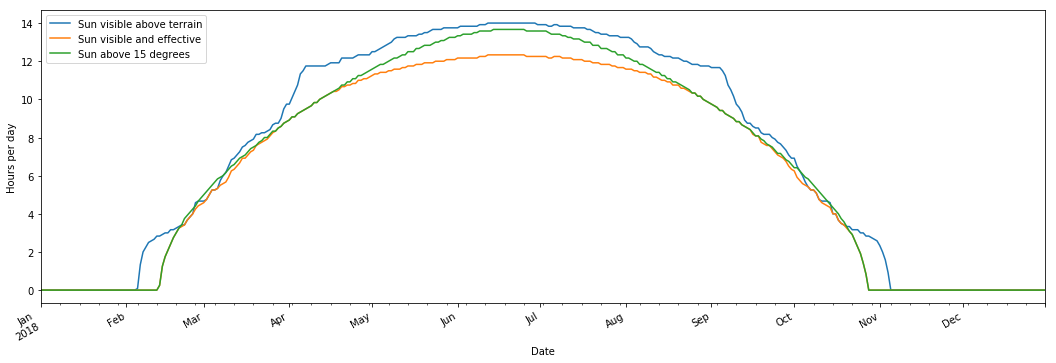

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))
 
df_dailysums.plot(ax=ax)
 
ax.set(xlabel='Date',
       ylabel='Hours per day')
 
ax.legend(loc=2)
fig.autofmt_xdate()

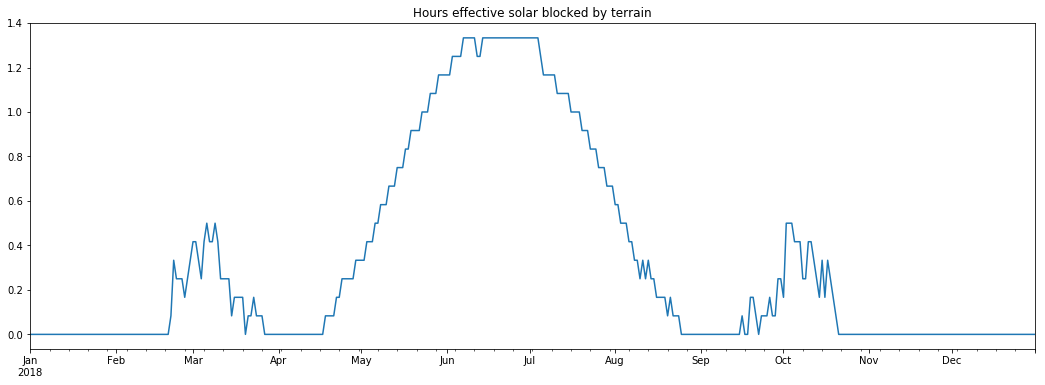

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))
df_dailysums['Sun above 15 degrees'].sub(df_dailysums['Sun visible and effective'], axis=0).plot(ax=ax)
ax.set(Title='Hours effective solar blocked by terrain')